# ЗАДАНИЕ 3. МОДЕЛИРОВАНИЕ ТРЕНДА НА ОСНОВЕ КРИВЫХ РОСТА

Постройте модель тренда, описывающую ряд данных по ценам на материал 1. Рассчитайте показатели точности и адекватности построенной модели. Дайте точечный и интервальный прогнозы на 1 год вперёд по построенной модели.

# Раздел 1. Аналитическое выравнивание временных рядов

Прочитаем данные по ценам на материал 1 и приведем их к виду, пригодному для дальнейшего анализа.

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from math import sqrt
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
from pandas.plotting import autocorrelation_plot
import seaborn as sns
from numpy import sum as arraysum

In [2]:
data = pd.read_excel('data.xls', sheet_name='Material 1')
data.head()

,Unnamed: 0,Unnamed: 1,Рыночные цены на материал 1 (руб.),Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49
0,NaN,NaN,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,...,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00
1,№ организации,1.0,26.45,23.89,25.95,30.03,28.96,25.58,25.96,30.56,...,37.36,39.21,39.43,43.5,40.75,42.84,38.01,45.18,42.49,44.2
2,NaN,2.0,26.09,20.66,22.6,25.05,27.59,20.49,27.39,28.52,...,39.54,42.38,37.5,41.29,44.96,45.39,42.49,45.77,46.94,40.83
3,NaN,3.0,22.05,23.15,28.22,21.55,21.57,28.58,31.42,28.11,...,40.17,47.99,47.92,46.25,47.3,48.9,51.2,43.96,49.22,51.38
4,NaN,4.0,20.41,28.39,17.74,18.46,20.47,28.93,27.89,20.68,...,68.39,73.93,63.97,75.59,70.98,78.28,78.98,71.27,81.34,85.73


In [3]:
dates = data.loc[data.index == 0].values[0,2:]

In [4]:
val = data.loc[data.index == 54].values[0,2:]

In [5]:
data = {'Date':dates, 'Value':val}

In [6]:
df = pd.DataFrame(data)
df.head()

,Date,Value
0,2007-01-01,26.94
1,2007-02-01,22.48
2,2007-03-01,28.16
3,2007-04-01,20.62
4,2007-05-01,24.81


In [7]:
df = df.set_index('Date')
df.head(10)

,Value
Date,
2007-01-01,26.94
2007-02-01,22.48
2007-03-01,28.16
2007-04-01,20.62
2007-05-01,24.81
2007-06-01,31.57
2007-07-01,31.94
2007-08-01,30.57
2007-09-01,25.93


In [8]:
df.size

48

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2007-01-01 to 2010-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Value   48 non-null     object
dtypes: object(1)
memory usage: 768.0+ bytes


In [10]:
df.Value = df.Value.astype(float)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2007-01-01 to 2010-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


Убедимся в том, что работаем с объектом Series, а не DataFrame. Превратить таблицу с одним столбцом целевых значений в объект Series можно с помощью функции squeeze(). Дадим ему название series.

In [12]:
ser = df.squeeze()
type(ser)

pandas.core.series.Series

Рассмотрим возможность построения линейного тренда визуально с помощью функции regplot(x=x, y=y, data= data) из модуля seaborn. В качестве x возьмем номера наблюдений, а y – значения цены на материал 1.

In [13]:
y = ser.values

In [14]:
t = np.arange(1, len(y)+1)
t

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

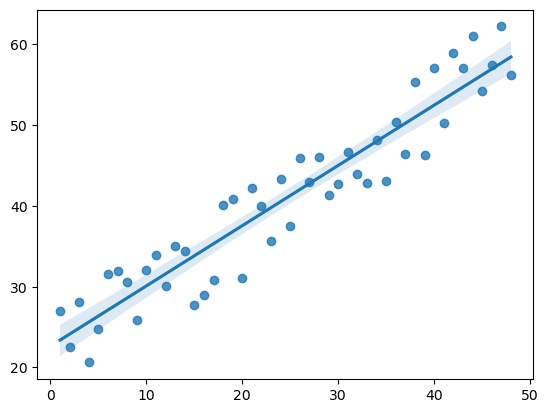

In [15]:
sns.regplot(x=t, y=y)
plt.show()

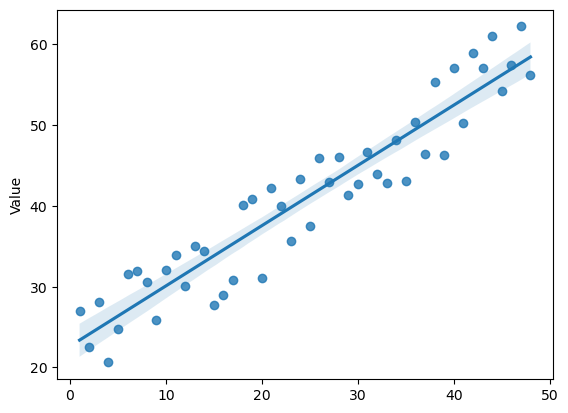

In [16]:
sns.regplot(x=t, y='Value', data=df)
plt.show()

Разделим исходные данные на обучающий и тестовый наборы в пропорции 80%:20%. Для этого создадим переменную y, в которую запишем значения временного ряда, обратившись к параметру values. Затем создадим переменную train, содержащую обучающую выборку, которая составляет 80% от количества наблюдений, и переменную test, содержащую тестовый набор из 20% выборки. Выведем на экран объем обучающей и тестовой выборки.

In [17]:
train_size = int(len(y)*0.8)
print(train_size)

38


In [18]:
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [19]:
len(y_train)

38

In [20]:
len(y_test)

10

Поместим в переменную t_train номера наблюдений обучающего набора, воспользовавшись функцией arange() из модуля numpy. Выведем на экран содержимое t_train.

In [21]:
t_train = np.arange(1, len(y_train)+1)
print(t_train)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


На основе переменной t_train, которая выступает в качестве факторного признака, и переменной y_train с ценами на материал 1 из обучающего набора в качестве результативного признака обучим полином первой степени, воспользовавшись функцией polyfit() из модуля numpy. Результат запишем в переменную coef. Выведем на экран полученные коэффициенты модели.

In [22]:
coef = np.polyfit(t_train, y_train, deg=1) 
coef

array([ 0.68949666, 23.4671835 ])

Поместим в переменную t_test номера наблюдений тестового набора, воспользовавшись функцией arange() из модуля numpy. Выведем на экран содержимое t_ test.

In [23]:
t_test = np.arange(len(y_train)+1, len(y)+1)
print(t_test)

[39 40 41 42 43 44 45 46 47 48]


Найдем расчетные значения цены на материал 1 по модели линейного тренда, воспользовавшись найденными коэффициентами: coef[0] – коэффициент при факторном признаке, coef[1] – свободный член. Выведем на экран полученный результат.

In [24]:
y_pred = coef[0]*t_test + coef[1]
print(y_pred)

[50.35755334 51.04705001 51.73654667 52.42604333 53.11553999 53.80503666
 54.49453332 55.18402998 55.87352664 56.56302331]


Оценим точность модели на тестовой выборке на основе коэффициента детерминации, воспользовавшись функцией r2_score(y_test, y_pred) из модуля sklearn.metrics.

In [25]:
r2 = r2_score(y_test, y_pred)
print(r2)

-0.021261866530657647


Аналогично найдем расчетные значения цены на материал 1 по модели линейного тренда с помощью функции linregress(t_train, y_train) из модуля scipy.stats. Рассчитаем коэффициент детерминации для тестового набора. Сравним полученный результат с предыдущим.

In [26]:
coef = linregress(t_train, y_train)
coef

LinregressResult(slope=0.6894966626545572, intercept=23.46718349928875, rvalue=0.9083154849263337, pvalue=3.4133034931672882e-15, stderr=0.0529196890048713, intercept_stderr=1.1839117318991033)

In [27]:
y_pred = coef[0]*t_test + coef[1]
print(y_pred)

[50.35755334 51.04705001 51.73654667 52.42604333 53.11553999 53.80503666
 54.49453332 55.18402998 55.87352664 56.56302331]


In [28]:
r2 = r2_score(y_test, y_pred)
print(r2)

-0.021261866530664086


In [29]:
t_train = t_train.reshape(-1,1)

Обучим на обучающем наборе данных модель линейного тренда на основе функций LinearRegression().fit() из модуля sklearn.linear_model. Выведем на экран полученные коэффициенты модели, воспользовавшись параметром coef_ для вывода коэффициента при номере наблюдения и параметром intercept_ - для свободного члена.

In [30]:
model = LinearRegression().fit(t_train, y_train)

In [31]:
model.coef_

array([0.68949666])

In [32]:
model.intercept_

23.46718349928875

Найдем расчетные значения цены на материал 1 для тестового набора данных по модели линейного тренда, воспользовавшись функцией predict(). Выведем на экран полученный результат.

In [33]:
t_test = t_test.reshape(-1,1)

In [34]:
y_pred = model.predict(t_test)
print(y_pred)

[50.35755334 51.04705001 51.73654667 52.42604333 53.11553999 53.80503666
 54.49453332 55.18402998 55.87352664 56.56302331]


Оценим точность модели на тестовой выборке на основе коэффициента детерминации, воспользовавшись функцией r2_score(y_test, y_pred) из модуля sklearn.metrics.

In [35]:
r2 = r2_score(y_test, y_pred)
print(r2)

-0.021261866530662088


Оценим точность модели на тестовой выборке на основе средней абсолютной ошибки (MAE), воспользовавшись функцией mean_absolute_error(y_test, y_pred) из модуля sklearn.metrics.

In [36]:
MAE = mean_absolute_error(y_test, y_pred) 
print(MAE)

3.85204300251669


Оценим точность модели на тестовой выборке на основе средней квадратичной ошибки (MSE), воспользовавшись функцией mean_squared_error(y_test, y_pred) из модуля sklearn.metrics.

In [37]:
MSE = mean_squared_error(y_test, y_pred) 
print(MSE)

21.097284829454942


Оценим точность модели на тестовой выборке на основе корня квадратного из среднеквадратичной ошибки (RMSE) для всех сделанных прогнозов, воспользовавшись функцией sqrt() из модуля math и функцией mean_squared_error(y_test, y_pred) из модуля sklearn.metrics.

In [38]:
RMSE = sqrt(MSE)
print(RMSE)

4.593178075086458


Рассчитаем прогнозные значения на тестовой выборке по базовой модели, которая в качестве прогноза выдает прошлое значение. Результат запишем в переменную y_pred.

In [39]:
y_pred = y[len(y_train)-1:len(y)-1]
print(y_pred)

[55.39 46.31 57.11 50.29 58.92 57.12 61.03 54.19 57.44 62.2 ]


Оценим точность базовой модели на тестовой выборке на основе средней квадратичной ошибки (MSE), воспользовавшись функцией mean_squared_error(y_test, y_pred) из модуля sklearn.metrics.

In [40]:
MSE = mean_squared_error(y_test, y_pred) 
print(MSE)

45.448960000000014


Обучим на всех данных лучшую модель.

In [41]:
t = t.reshape(-1,1)

In [42]:
model = LinearRegression().fit(t, y)

In [43]:
model.coef_

array([0.74554766])

In [44]:
model.intercept_

22.640124113475174

In [45]:
y_pred = model.predict(t)
print(y_pred)

[23.38567177 24.13121942 24.87676708 25.62231473 26.36786239 27.11341004
 27.8589577  28.60450536 29.35005301 30.09560067 30.84114832 31.58669598
 32.33224363 33.07779129 33.82333894 34.5688866  35.31443425 36.05998191
 36.80552956 37.55107722 38.29662487 39.04217253 39.78772018 40.53326784
 41.27881549 42.02436315 42.7699108  43.51545846 44.26100612 45.00655377
 45.75210143 46.49764908 47.24319674 47.98874439 48.73429205 49.4798397
 50.22538736 50.97093501 51.71648267 52.46203032 53.20757798 53.95312563
 54.69867329 55.44422094 56.1897686  56.93531625 57.68086391 58.42641156]


Найдем расчетные значения по модели для всех данных. Рассчитаем ошибки модели для всех данных. Поместим столбец ошибок 'Error' в таблицу исходных данных. Выведем на экран первые 5 наблюдений.

In [46]:
df['Error'] = y - y_pred
df.head()

,Value,Error
Date,,
2007-01-01,26.94,3.554328
2007-02-01,22.48,-1.651219
2007-03-01,28.16,3.283233
2007-04-01,20.62,-5.002315
2007-05-01,24.81,-1.557862


In [47]:
err = df.Error

Построим линейный график ошибок, воспользовавшись функцией plot() и командой pyplot.show() из модуля matplotlib.

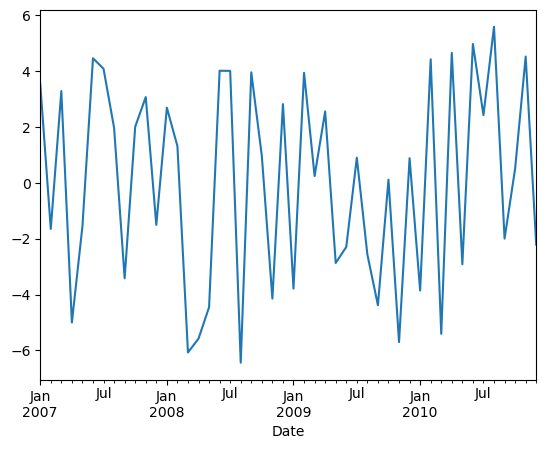

In [48]:
err.plot()
plt.show()

Выведем на экран описательные статистики ошибок, воспользовавшись функцией describe().

In [49]:
err.describe()

count    4.800000e+01
mean     5.403085e-15
std      3.656526e+00
min     -6.441077e+00
25%     -3.043197e+00
50%      6.924220e-01
75%      3.351007e+00
max      5.585779e+00
Name: Error, dtype: float64

Построим для ошибок гистограмму на основе функции hist(), ядерную оценку плотности на основе функции plot(kind='kde'), Q-Q график на основе функции qqplot() из модуля statsmodels.graphics.gofplots, а также функцией show() из matplotlib.pyplot.

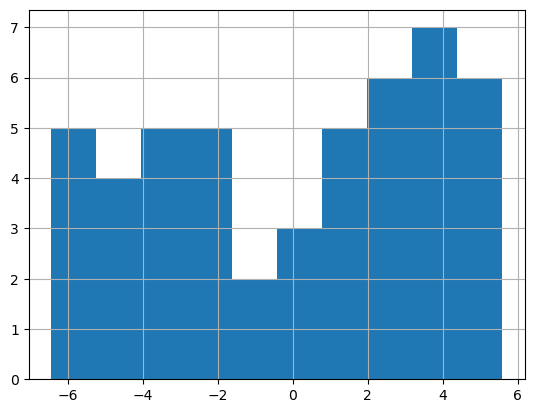

In [50]:
err.hist()
plt.show()

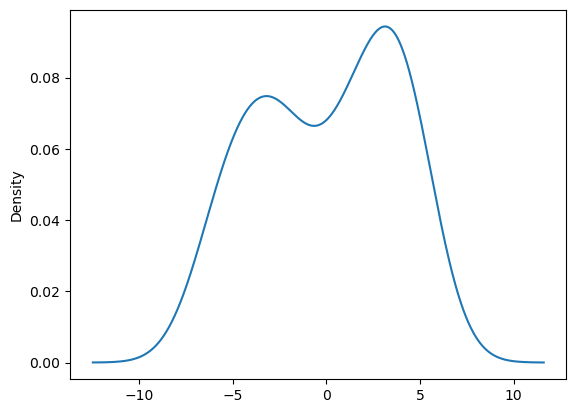

In [51]:
err.plot(kind='kde')
plt.show()

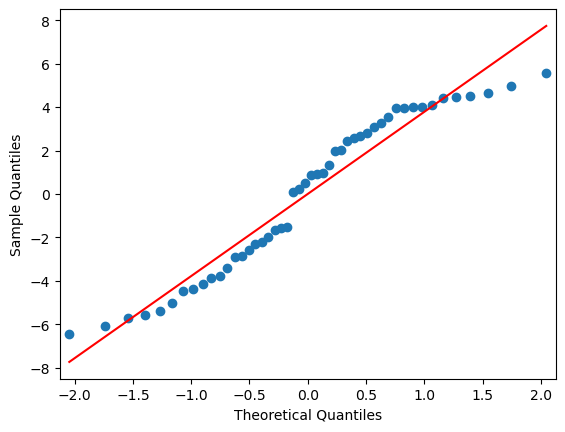

In [52]:
qqplot(err, line='r')
plt.show()

Оценим адекватность модели линейного тренда на основе теста Дарбина-Уотсона, воспользовавшись функцией durbin_watson() из модуля statsmodels.stats.stattools применительно к остаткам модели.

In [53]:
d = durbin_watson(err)
print(d)

2.4281062954008767


In [54]:
4-d

1.5718937045991233

n=50, dl=1.5, du=1.59, 1.5<1.57<1.59. Попали в зону неопределенности

Построим для ошибок линейного тренда коррелограмму, воспользовавшись функцией autocorrelation_plot() из модуля pandas.plotting.

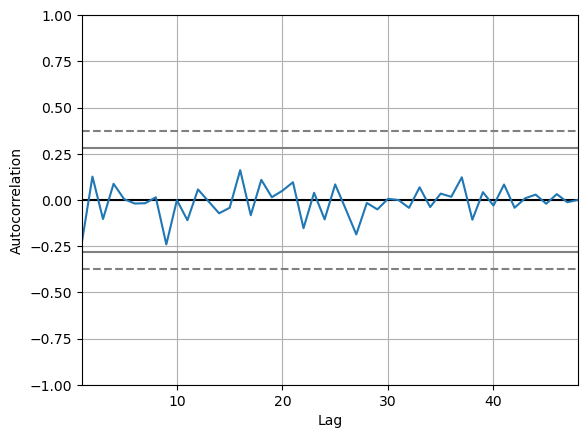

In [55]:
autocorrelation_plot(err)
plt.show()

Сгенерируем номера наблюдений для прогнозного интервала, равного 12 месяцев. Запишем результат в переменную t_new и выведем его на экран.

In [56]:
t_new = np.arange(len(y)+1, len(y)+13)
print(t_new)

[49 50 51 52 53 54 55 56 57 58 59 60]


In [57]:
t_new = t_new.reshape(-1,1)

Найдем прогнозные значения цены на материал 1 на год вперед (точечный прогноз). Запишем результат в переменную y_new и выведем его на экран.

In [58]:
y_new = model.predict(t_new)
print(y_new)

[59.17195922 59.91750688 60.66305453 61.40860219 62.15414984 62.8996975
 63.64524515 64.39079281 65.13634046 65.88188812 66.62743577 67.37298343]


Рассчитаем среднее квадратичное отклонение.

In [59]:
sum_errs = arraysum((y - y_pred)**2)

In [60]:
stdev = sqrt(1/(len(y)-2) * sum_errs)
print(stdev)

3.6960573441463027


Рассчитаем 95% доверительный интервал.

In [61]:
z = 1.96 # доверительный интервал 95%
interval = z * stdev
print('Prediction Interval: %.3f' % interval)

Prediction Interval: 7.244


Рассчитаем верхнюю и нижнюю границу прогнозного интервала.


In [62]:
y_down, y_up = y_new - interval, y_new + interval

Нанесем на одну диаграмму фактические значения, значения по модели, точечный и интервальный прогнозы, воспользовавшись функциями figure(), scatter(), plot(), xlabel(), ylabel(), legend() и show() из модуля matplotlib.pyplot.

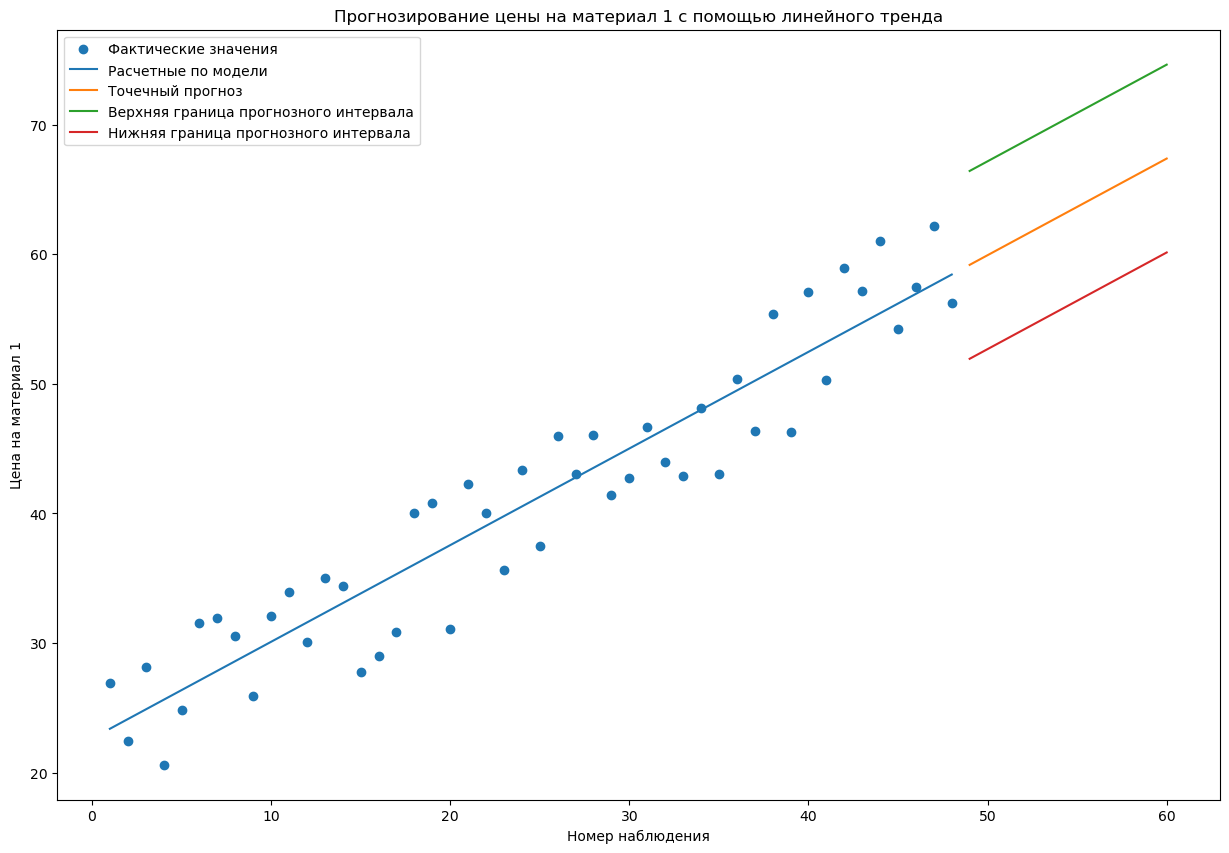

In [65]:
plt.figure(figsize=(15,10))

plt.scatter(t, y)
plt.plot(t, y_pred)
plt.plot(t_new, y_new)
plt.plot(t_new, y_up)
plt.plot(t_new, y_down)

plt.title('Прогнозирование цены на материал 1 с помощью линейного тренда')
plt.xlabel('Номер наблюдения')
plt.ylabel('Цена на материал 1')
plt.legend(['Фактические значения','Расчетные по модели','Точечный прогноз','Верхняя граница прогнозного интервала','Нижняя граница прогнозного интервала'])

plt.show()

Приближенное вычисление условного стандарного отклонения для прогнозного интервала

In [64]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y, y_pred))
print(rms)

3.6182368951028825
